lstm5

 과정 요약: sales를 normalize 한 후 log를 취한다.-> normalize의 결과 0이 된 값들이(min) log를 씌우자 -inf가 되어 버렸다.이를 방지하기 위해 자료를 찾아보니  box cox transformation, log(x+1)로 shift, 루트 변환 등 새로운 내용을 알게 되었다. 일단 가장 간단한 log(x+1)변환을 시도하기로 했는데, data transformation도 자료의 형태와 그 숫자가 의미하는 바에 따라 처리방식이 매우 달라진다고 한다. 예를 들어 숫자가 모두 0에서 1 사이에 있을 때는 +1을 하는 것이 'mayhem'이라고 한다. 따라서 나는 log를 한 후 normalize를 하는 방식을 선택하기로 했다. lstm6. 그리고, lstm7에서는 루트를 한 후 normalize를 시도하겠다.

결과요약: RMSE: nan 

Data import

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 제외함

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(7)


In [2]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]


In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
txs

,date,sales,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

# 3. 추가 가공

## 이상점 제거

이상점 제거의 기준이 무척 주관적일 수 있으므로 제외하는 것이 좋을 수도 있어 lstm5는 이상점 제거를 하지 않았다.

normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

## Normalization

In [7]:
xySales=txs['sales']
xySales=list(xySales)

In [8]:
xySales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

In [9]:
def MinMaxScaler(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

In [10]:
xySales=MinMaxScaler(xySales)

In [11]:
xySales

array([ 0.05964912,  0.07192982,  0.09473684,  0.07192982,  0.06140351,
        0.07719298,  0.0877193 ,  0.07368421,  0.07368421,  0.11578947,
        0.0877193 ,  0.09649123,  0.09824561,  0.09298246,  0.07719298,
        0.09473684,  0.09473684,  0.0877193 ,  0.07017544,  0.08596491,
        0.04912281,  0.12631579,  0.1245614 ,  0.09298246,  0.0754386 ,
        0.06666667,  0.09649123,  0.08596491,  0.0754386 ,  0.08596491,
        0.08596491,  0.07719298,  0.06842105,  0.09122807,  0.07894737,
        0.05789474,  0.0754386 ,  0.07017544,  0.08070175,  0.08596491,
        0.0877193 ,  0.06491228,  0.06491228,  0.07894737,  0.08421053,
        0.08421053,  0.06666667,  0.10526316,  0.05438596,  0.06140351,
        0.09298246,  0.12280702,  0.10877193,  0.08421053,  0.08947368,
        0.08596491,  0.06666667,  0.05614035,  0.06842105,  0.06140351,
        0.05263158,  0.06315789,  0.05438596,  0.05438596,  0.07719298,
        0.07192982,  0.07192982,  0.07894737,  0.08070175,  0.07

## log

In [12]:
def second_smallest(numbers):
    m1, m2 = float('inf'), float('inf')
    for x in numbers:
        if x < m1:
            m1, m2 = x, m1
        elif x < m2:
            m2 = x
    return m2

참고로 아래 5줄 정도는 normalize를 한 결과 생성된 0을 2번째로 작은 수로 바꾸기 위한 시도였는데, 그 시도가 상당히 작위적이고 인위적이라 느껴져서 시도를 중단하였다.

In [13]:
a=[0,1,2,1,0]

In [14]:
b = []
for i in range(len(a)):
    b.append(1 - min(filter(lambda x: x>0, a[i])))

TypeError: 'int' object is not iterable

In [15]:
secondMin=second_smallest(xySales)

In [ ]:
secondMin

In [ ]:
def prevent0BeforeLog(f):
    for i in f:
        if i is 0: 
            i=secondMin

In [16]:
xySales=prevent0BeforeLog(xySales)

NameError: name 'prevent0BeforeLog' is not defined

In [17]:
xySales=np.log(xySales)

c:\users\lg\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


## 합쳐서 최종 input XY생성

In [18]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),xySales]

In [19]:
tempxy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [20]:
xy=np.array(tempxy)

In [21]:
xy

array([['0', '0', '0', ..., '0', '0', '0'],
       ['4', '5', '6', ..., '6', '0', '1'],
       ['53', '53', '53', ..., '04', '05', '05'],
       ['-2.819275836387873', '-2.6320642942997265', '-2.35665231443976',
        ..., '-inf', '-4.736198448569934', '-2.9116491565188882']], 
      dtype='<U32')

In [22]:
temp=xy.transpose()

In [23]:
temp

array([['0', '4', '53', '-2.819275836387873'],
       ['0', '5', '53', '-2.6320642942997265'],
       ['0', '6', '53', '-2.35665231443976'],
       ..., 
       ['0', '6', '04', '-inf'],
       ['0', '0', '05', '-4.736198448569934'],
       ['0', '1', '05', '-2.9116491565188882']], 
      dtype='<U32')

In [24]:
xy = temp.astype(np.float)

In [25]:
xy

array([[  0.        ,   4.        ,  53.        ,  -2.81927584],
       [  0.        ,   5.        ,  53.        ,  -2.63206429],
       [  0.        ,   6.        ,  53.        ,  -2.35665231],
       ..., 
       [  0.        ,   6.        ,   4.        ,         -inf],
       [  0.        ,   0.        ,   5.        ,  -4.73619845],
       [  0.        ,   1.        ,   5.        ,  -2.91164916]])

[[  0.           4.          53.          -2.81927584]
 [  0.           5.          53.          -2.63206429]
 [  0.           6.          53.          -2.35665231]
 [  0.           0.           1.          -2.63206429]
 [  0.           1.           1.          -2.7902883 ]
 [  0.           2.           1.          -2.56144673]
 [  0.           3.           1.          -2.43361336]] -> [-2.60796674]
[[  0.           5.          53.          -2.63206429]
 [  0.           6.          53.          -2.35665231]
 [  0.           0.           1.          -2.63206429]
 [  0.           1.           1.          -2.7902883 ]
 [  0.           2.           1.          -2.56144673]
 [  0.           3.           1.          -2.43361336]
 [  0.           4.           1.          -2.60796674]] -> [-2.60796674]
[[  0.           6.          53.          -2.35665231]
 [  0.           0.           1.          -2.63206429]
 [  0.           1.           1.          -2.7902883 ]
 [  0.           2.          

 [  1.           3.          12.          -1.95118721]] -> [-2.65675691]
[[  1.           5.          11.          -2.47443535]
 [  1.           6.          11.          -2.21850198]
 [  1.           0.          12.          -2.51699496]
 [  1.           1.          12.          -2.7080502 ]
 [  1.           2.          12.          -2.21850198]
 [  1.           3.          12.          -1.95118721]
 [  1.           4.          12.          -2.65675691]] -> [-2.53897387]
[[  1.           6.          11.          -2.21850198]
 [  1.           0.          12.          -2.51699496]
 [  1.           1.          12.          -2.7080502 ]
 [  1.           2.          12.          -2.21850198]
 [  1.           3.          12.          -1.95118721]
 [  1.           4.          12.          -2.65675691]
 [  1.           5.          12.          -2.53897387]] -> [-2.60796674]
[[  1.           0.          12.          -2.51699496]
 [  1.           1.          12.          -2.7080502 ]
 [  1.     

 [  3.           0.          42.          -2.87990046]] -> [-3.40119738]
[[  3.           2.          41.          -3.30111392]
 [  3.           3.          41.          -2.97834053]
 [  3.           4.          41.          -1.54984582]
 [  3.           5.          41.                 -inf]
 [  3.           6.          41.          -4.39972621]
 [  3.           0.          42.          -2.87990046]
 [  3.           1.          42.          -3.40119738]] -> [-2.81927584]
[[  3.           3.          41.          -2.97834053]
 [  3.           4.          41.          -1.54984582]
 [  3.           5.          41.                 -inf]
 [  3.           6.          41.          -4.39972621]
 [  3.           0.          42.          -2.87990046]
 [  3.           1.          42.          -3.40119738]
 [  3.           2.          42.          -2.81927584]] -> [-3.01343185]
[[  3.           4.          41.          -1.54984582]
 [  3.           5.          41.                 -inf]
 [  3.     

[step: 37] loss: nan
[step: 38] loss: nan
[step: 39] loss: nan
[step: 40] loss: nan
[step: 41] loss: nan
[step: 42] loss: nan
[step: 43] loss: nan
[step: 44] loss: nan
[step: 45] loss: nan
[step: 46] loss: nan
[step: 47] loss: nan
[step: 48] loss: nan
[step: 49] loss: nan
[step: 50] loss: nan
[step: 51] loss: nan
[step: 52] loss: nan
[step: 53] loss: nan
[step: 54] loss: nan
[step: 55] loss: nan
[step: 56] loss: nan
[step: 57] loss: nan
[step: 58] loss: nan
[step: 59] loss: nan
[step: 60] loss: nan
[step: 61] loss: nan
[step: 62] loss: nan
[step: 63] loss: nan
[step: 64] loss: nan
[step: 65] loss: nan
[step: 66] loss: nan
[step: 67] loss: nan
[step: 68] loss: nan
[step: 69] loss: nan
[step: 70] loss: nan
[step: 71] loss: nan
[step: 72] loss: nan
[step: 73] loss: nan
[step: 74] loss: nan
[step: 75] loss: nan
[step: 76] loss: nan
[step: 77] loss: nan
[step: 78] loss: nan
[step: 79] loss: nan
[step: 80] loss: nan
[step: 81] loss: nan
[step: 82] loss: nan
[step: 83] loss: nan
[step: 84] lo

[step: 447] loss: nan
[step: 448] loss: nan
[step: 449] loss: nan
[step: 450] loss: nan
[step: 451] loss: nan
[step: 452] loss: nan
[step: 453] loss: nan
[step: 454] loss: nan
[step: 455] loss: nan
[step: 456] loss: nan
[step: 457] loss: nan
[step: 458] loss: nan
[step: 459] loss: nan
[step: 460] loss: nan
[step: 461] loss: nan
[step: 462] loss: nan
[step: 463] loss: nan
[step: 464] loss: nan
[step: 465] loss: nan
[step: 466] loss: nan
[step: 467] loss: nan
[step: 468] loss: nan
[step: 469] loss: nan
[step: 470] loss: nan
[step: 471] loss: nan
[step: 472] loss: nan
[step: 473] loss: nan
[step: 474] loss: nan
[step: 475] loss: nan
[step: 476] loss: nan
[step: 477] loss: nan
[step: 478] loss: nan
[step: 479] loss: nan
[step: 480] loss: nan
[step: 481] loss: nan
[step: 482] loss: nan
[step: 483] loss: nan
[step: 484] loss: nan
[step: 485] loss: nan
[step: 486] loss: nan
[step: 487] loss: nan
[step: 488] loss: nan
[step: 489] loss: nan
[step: 490] loss: nan
[step: 491] loss: nan
[step: 492

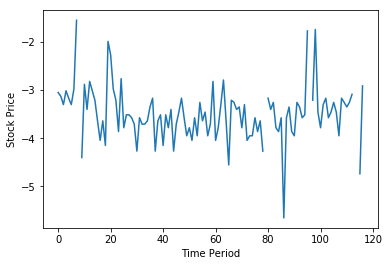

[step: 0] loss: inf
[step: 1] loss: nan
[step: 2] loss: nan
[step: 3] loss: nan
[step: 4] loss: nan
[step: 5] loss: nan
[step: 6] loss: nan
[step: 7] loss: nan
[step: 8] loss: nan
[step: 9] loss: nan
[step: 10] loss: nan
[step: 11] loss: nan
[step: 12] loss: nan
[step: 13] loss: nan
[step: 14] loss: nan
[step: 15] loss: nan
[step: 16] loss: nan
[step: 17] loss: nan
[step: 18] loss: nan
[step: 19] loss: nan
[step: 20] loss: nan
[step: 21] loss: nan
[step: 22] loss: nan
[step: 23] loss: nan
[step: 24] loss: nan
[step: 25] loss: nan
[step: 26] loss: nan
[step: 27] loss: nan
[step: 28] loss: nan
[step: 29] loss: nan
[step: 30] loss: nan
[step: 31] loss: nan
[step: 32] loss: nan
[step: 33] loss: nan
[step: 34] loss: nan
[step: 35] loss: nan
[step: 36] loss: nan
[step: 37] loss: nan
[step: 38] loss: nan
[step: 39] loss: nan
[step: 40] loss: nan
[step: 41] loss: nan
[step: 42] loss: nan
[step: 43] loss: nan
[step: 44] loss: nan
[step: 45] loss: nan
[step: 46] loss: nan
[step: 47] loss: nan
[s

[step: 382] loss: nan
[step: 383] loss: nan
[step: 384] loss: nan
[step: 385] loss: nan
[step: 386] loss: nan
[step: 387] loss: nan
[step: 388] loss: nan
[step: 389] loss: nan
[step: 390] loss: nan
[step: 391] loss: nan
[step: 392] loss: nan
[step: 393] loss: nan
[step: 394] loss: nan
[step: 395] loss: nan
[step: 396] loss: nan
[step: 397] loss: nan
[step: 398] loss: nan
[step: 399] loss: nan
[step: 400] loss: nan
[step: 401] loss: nan
[step: 402] loss: nan
[step: 403] loss: nan
[step: 404] loss: nan
[step: 405] loss: nan
[step: 406] loss: nan
[step: 407] loss: nan
[step: 408] loss: nan
[step: 409] loss: nan
[step: 410] loss: nan
[step: 411] loss: nan
[step: 412] loss: nan
[step: 413] loss: nan
[step: 414] loss: nan
[step: 415] loss: nan
[step: 416] loss: nan
[step: 417] loss: nan
[step: 418] loss: nan
[step: 419] loss: nan
[step: 420] loss: nan
[step: 421] loss: nan
[step: 422] loss: nan
[step: 423] loss: nan
[step: 424] loss: nan
[step: 425] loss: nan
[step: 426] loss: nan
[step: 427

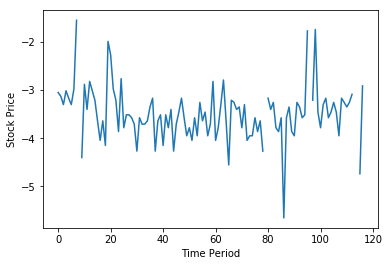

In [26]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.


x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()


처음에 normalization을 하고, log를 씌웠을 때 0이라는 값이 있어서 -inf가 나오고 오류가 생겼던 것 같다. 